# Visualizing the processes carried out by the trained RNN
### Requires python >= 3.7, pytorch >= 1.6.0, and seaborn
### You can download two pretrained RNNs from the associated OSF repository: https://osf.io/pf4u5/ and place them under models/, or you can train a RNN using the RNN_gen.py script and assess it here.

## Importing the relevant modules, setting plotting variables, and importing the raw datasets

In [1]:
import torch
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.ndimage import zoom
from scipy.ndimage import rotate
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

plt.rc('axes', facecolor='#FFFFFF', edgecolor='black',
       axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Obtaining MNIST and fashionMNIST in the required formats

In [2]:
class MNISTData:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

class MNIST:
    def __init__(self, dataset_name='mnist'):
        if dataset_name == 'mnist':
            dataset = datasets.MNIST
        elif dataset_name == 'fashionmnist':
            dataset = datasets.FashionMNIST
        else:
            raise ValueError("dataset_name must be either 'mnist' or 'fashionmnist'")
        
        # Load datasets
        train_dataset = dataset(root='./data', train=True, download=True)
        test_dataset = dataset(root='./data', train=False, download=True)
        
        # Extract images and labels
        train_images = train_dataset.data.numpy()
        train_labels = self.one_hot(train_dataset.targets.numpy())
        test_images = test_dataset.data.numpy()
        test_labels = self.one_hot(test_dataset.targets.numpy())
        
        # Create validation set from the training set
        val_size = 5000
        train_size = len(train_images) - val_size
        
        train_images, val_images = train_images[:train_size], train_images[train_size:]
        train_labels, val_labels = train_labels[:train_size], train_labels[train_size:]
        
        # Store datasets in MNIST-like structure
        self.train = MNISTData(train_images, train_labels)
        self.validation = MNISTData(val_images, val_labels)
        self.test = MNISTData(test_images, test_labels)
        
    def one_hot(self, labels, num_classes=10):
        return np.eye(num_classes)[labels]

# Example usage:
mnist = MNIST(dataset_name='mnist')
fmnist = MNIST(dataset_name='fashionmnist')

# Check the structure
print(f"MNIST Train images shape: {mnist.train.images.shape}")
print(f"MNIST Validation images shape: {mnist.validation.images.shape}")
print(f"MNIST Test images shape: {mnist.test.images.shape}")

print(f"FashionMNIST Train images shape: {fmnist.train.images.shape}")
print(f"FashionMNIST Validation images shape: {fmnist.validation.images.shape}")
print(f"FashionMNIST Test images shape: {fmnist.test.images.shape}")


MNIST Train images shape: (55000, 28, 28)
MNIST Validation images shape: (5000, 28, 28)
MNIST Test images shape: (10000, 28, 28)
FashionMNIST Train images shape: (55000, 28, 28)
FashionMNIST Validation images shape: (5000, 28, 28)
FashionMNIST Test images shape: (10000, 28, 28)


## Functions defined

In [3]:
def im_scram(im,parts_h): # scramble parts_h*parts_h equal parts of the given image
    win_prop = parts_h
    dimsh = np.shape(im)
    im_new = np.zeros(dimsh)
    dimsh_win = np.floor(dimsh[0]/win_prop)
    n_cells = np.square(int(dimsh[0]/dimsh_win))
    cell_c = int(dimsh[0]/dimsh_win)
    ind_new = np.linspace(0,n_cells-1,n_cells).astype('int32')
    while np.mean(ind_new == np.linspace(0,n_cells-1,n_cells).astype('int32')) == 1:
        shuffle(ind_new)
    for i in range(n_cells):
        j = ind_new[i]
        im_new[int(np.mod(i,cell_c)*dimsh_win):int(np.mod(i,cell_c)*dimsh_win+dimsh_win),
               int(np.floor(i*1./cell_c*1.)*dimsh_win):int(np.floor(i*1./cell_c*1.)*dimsh_win+dimsh_win)] = im[
            int(np.mod(j,cell_c)*dimsh_win):int(np.mod(j,cell_c)*dimsh_win+dimsh_win),
            int(np.floor(j*1./cell_c*1.)*dimsh_win):int(np.floor(j*1./cell_c*1.)*dimsh_win+dimsh_win)]
    return im_new

def gen_images(n_imgs,n_set): # n_imgs required, set used (0 train, 1 val, 2 test) 8 objects in image (1 is intact), 2 levels of zoom, rotation and x/y pos for each object
    imgs_h = np.zeros([n_imgs,1,100,100])
    imgs_h1 = np.zeros([n_imgs,1,100,100])
    labs_h = np.zeros([n_imgs,20])
    pos_x_h = np.zeros([n_imgs,2])
    pos_y_h = np.zeros([n_imgs,2])
    size_h = np.zeros([n_imgs,2])
    rot_h = np.zeros([n_imgs,2])
    n_objs = 8
    for n_im in np.arange(n_imgs):
        inst_img = np.zeros([100,100])
        inst_img1 = np.zeros([100,100])
        obj_ord = np.linspace(0,n_objs-1,n_objs)
        dum_obj_ind = 4+np.random.randint(n_objs/2)
        dum_dat_ord = (np.random.random(8) < 0.5)*1.
        for i in np.arange(n_objs):
            if dum_dat_ord[i] == 0: # dataset M or F
                if n_set == 0:
                    dathh = mnist.train
                elif n_set == 1:
                    dathh = mnist.validation
                elif n_set == 2:
                    dathh = mnist.test
                inst_obj_ind = np.random.randint(np.shape(dathh.images)[0])
                if i == dum_obj_ind:
                    inst_lab = np.where(dathh.labels[inst_obj_ind,:]==1)[0][0]
                inst_obj = np.reshape(dathh.images[inst_obj_ind,:],(28,28))
            else:
                if n_set == 0:
                    dathh = fmnist.train
                elif n_set == 1:
                    dathh = fmnist.validation
                elif n_set == 2:
                    dathh = fmnist.test
                inst_obj_ind = np.random.randint(np.shape(dathh.images)[0])
                if i == dum_obj_ind:
                    inst_lab = 10 + np.where(dathh.labels[inst_obj_ind,:]==1)[0][0]
                inst_obj = np.reshape(dathh.images[inst_obj_ind,:],(28,28))
            dumh111 = (np.random.random(1)[0] > 0.5)*1
            if dumh111 == 0: # zoom 0.9 or 1.5
                inst_obj = zoom(inst_obj,0.9+(np.random.random(1)[0]-0.5)/5.) # zoom 0.8 to 1.
            else:
                inst_obj = zoom(inst_obj,1.5+(np.random.random(1)[0]-0.5)/5.) # zoom 1.4 to 1.6
            if i == dum_obj_ind:
                size_h[n_im,dumh111] = 1.
            dumh111 = (np.random.random(1)[0] > 0.5)*1
            if dumh111 == 0: # rotate 30 or -30
                inst_obj = rotate(inst_obj,30+(np.random.random(1)[0]-0.5)*2*5,reshape=False) # rotate 25 to 35
            else:
                inst_obj = rotate(inst_obj,-30+(np.random.random(1)[0]-0.5)*2*5,reshape=False) # rotate -25 to -35
            if i == dum_obj_ind:
                rot_h[n_im,dumh111] = 1.
            if i != dum_obj_ind:
                inst_obj = im_scram(inst_obj,3) # scrambled if not object of interest
            if np.mod(obj_ord[i],4) == 0: # x_loc up or down
                x_loc = int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                y_loc = int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,0] = 1.
                    pos_x_h[n_im,0] = 1.
            elif np.mod(obj_ord[i],4) == 1:
                x_loc = int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                y_loc = int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,1] = 1.
                    pos_x_h[n_im,0] = 1.
            elif np.mod(obj_ord[i],4) == 2:
                x_loc = int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                y_loc = int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,0] = 1.
                    pos_x_h[n_im,1] = 1.
            elif np.mod(obj_ord[i],4) == 3:
                x_loc = int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                y_loc = int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,1] = 1.
                    pos_x_h[n_im,1] = 1.
            inst_obj = (inst_obj-np.min(inst_obj))/(np.max(inst_obj)-np.min(inst_obj))
            # print(int(np.floor(np.shape(inst_obj)[0]/2)),int(np.ceil(np.shape(inst_obj)[0]/2)),np.shape(inst_obj)[0])
            inst_img[x_loc-int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+int(np.ceil(np.shape(inst_obj)[1]/2.))] = (1-inst_obj)*inst_img[x_loc-int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+int(np.ceil(np.shape(inst_obj)[1]/2.))] + (inst_obj)*inst_obj
            if i == dum_obj_ind:
                inst_img1[x_loc-int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+int(np.ceil(np.shape(inst_obj)[1]/2.))] = (1-inst_obj)*inst_img1[x_loc-int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+int(np.ceil(np.shape(inst_obj)[1]/2.))] + (inst_obj)*inst_obj
        inst_img = (inst_img-np.min(inst_img))/(np.max(inst_img)-np.min(inst_img))
        inst_img1 = (inst_img1-np.min(inst_img1))/(np.max(inst_img1)-np.min(inst_img1))
        if np.isnan(np.min(inst_img)) or np.isnan(np.min(inst_img1)):
            print('NaN in input')
            exit(1)
        imgs_h[n_im,0,:,:] = inst_img
        imgs_h1[n_im,0,:,:] = inst_img1
        labs_h[n_im,inst_lab] = 1.
    return imgs_h,imgs_h1,labs_h,pos_x_h,pos_y_h,size_h,rot_h

In [4]:
# Defining the RNN class to be able to read out representations
class RNNet_all_fbr(nn.Module):
    def __init__(self, n_feats=8, ker_size=5,t_steps=3,b_flag=1,g_flag=1,l_flag=1,t_flag=1):
        super(RNNet_all_fbr, self).__init__()
        self.conv1 = nn.Conv2d(1, n_feats, ker_size)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(n_feats, n_feats*2, ker_size)
        self.fc1 = nn.Linear(n_feats*2 * 9 * 9, n_feats*16)
        self.fc2 = nn.Linear(n_feats*16*t_steps, 20)
        self.dropout = nn.Dropout(0.5)
        self.c1xb = nn.ConvTranspose2d(n_feats,1,7,3) # in_channel, out_channel, kernel_size, stride, padding
        self.c2xb = nn.ConvTranspose2d(n_feats*2,1,20,10)
        self.fc1xb = nn.Linear(n_feats*16, 100*100)
        self.c1c1b = nn.Conv2d(n_feats, n_feats, ker_size, 1, 2)
        self.c2c1b = nn.ConvTranspose2d(n_feats*2,n_feats,16,10)
        self.fc1c1b = nn.Linear(n_feats*16, 96*96*n_feats)
        self.c2c2b = nn.Conv2d(n_feats*2, n_feats*2, ker_size, 1, 2)
        self.fc1c2b = nn.Linear(n_feats*16, 28*28*n_feats*2)
        self.fc1fc1b = nn.Linear(n_feats*16, n_feats*16)
        self.c1xg = nn.ConvTranspose2d(n_feats,1,7,3) # in_channel, out_channel, kernel_size, stride, padding
        self.c2xg = nn.ConvTranspose2d(n_feats*2,1,20,10)
        self.fc1xg = nn.Linear(n_feats*16, 100*100)
        self.c1c1g = nn.Conv2d(n_feats, n_feats, ker_size, 1, 2)
        self.c2c1g = nn.ConvTranspose2d(n_feats*2,n_feats,16,10)
        self.fc1c1g = nn.Linear(n_feats*16, 96*96*n_feats)
        self.c2c2g = nn.Conv2d(n_feats*2, n_feats*2, ker_size, 1, 2)
        self.fc1c2g = nn.Linear(n_feats*16, 28*28*n_feats*2)
        self.fc1fc1g = nn.Linear(n_feats*16, n_feats*16)
        self.n_feats = n_feats
        self.t_steps = t_steps
        self.b_flag = b_flag
        self.g_flag = g_flag
        self.l_flag = l_flag
        self.t_flag = t_flag
    def forward(self, x):
        actvs = {}
        actvs[0] = {}
        actvs[1] = {}
        actvs[2] = {}
        actvs[3] = {}
        fb_acts = {}
        fb_acts[0] = {}
        fb_acts[1] = {}
        fb_acts[2] = {}
        fb_acts[3] = {}
        fb_acts_comb = {}
        fb_acts_comb[0] = {}
        fb_acts_comb[1] = {}
        fb_acts_comb[2] = {}
        fb_acts_comb[3] = {}
        for i in np.arange(2):
            fb_acts[0][i] = {}
            fb_acts[1][i] = {}
            fb_acts[2][i] = {}
            fb_acts[3][i] = {}
            fb_acts_comb[0][i] = {}
            fb_acts_comb[1][i] = {}
            fb_acts_comb[2][i] = {}
            fb_acts_comb[3][i] = {}
            for j in np.arange(3):
                fb_acts[0][i][j] = {}
                fb_acts[1][i][j] = {}
                if j > 0:
                    fb_acts[2][i][j-1] = {}
                    if j > 1:
                        fb_acts[3][i][j-2] = {}
        actvs[0][0] = F.relu(x) - F.relu(x-1)
        c1 = F.relu(self.conv1(actvs[0][0]))
        actvs[1][0] = self.pool(c1)
        c2 = F.relu(self.conv2(actvs[1][0]))
        actvs[2][0] = self.pool(c2)
        actvs[3][0] = F.relu(self.fc1(actvs[2][0].view(-1, self.n_feats*2 * 9 * 9)))
        actvs[4] = actvs[3][0]
        if self.t_steps > 0:
            for t in np.arange(self.t_steps-1):
                fb_acts[0][0][0][t] = self.t_flag*self.c1xb(actvs[1][t])
                fb_acts[0][0][1][t] = self.t_flag*self.c2xb(actvs[2][t])
                fb_acts[0][0][2][t] = self.t_flag*(self.fc1xb(actvs[3][t])).view(-1,1,100,100)
                fb_acts_comb[0][0][t] = fb_acts[0][0][0][t] + fb_acts[0][0][1][t] + fb_acts[0][0][2][t]
                fb_acts[0][1][0][t] = self.t_flag*self.c1xg(actvs[1][t])
                fb_acts[0][1][1][t] = self.t_flag*self.c2xg(actvs[2][t])
                fb_acts[0][1][2][t] = self.t_flag*(self.fc1xg(actvs[3][t])).view(-1,1,100,100)
                fb_acts_comb[0][1][t] = fb_acts[0][1][0][t] + fb_acts[0][1][1][t] + fb_acts[0][1][2][t]
                dumh000 = (x + self.b_flag*(self.t_flag*(self.c1xb(actvs[1][t])+self.c2xb(actvs[2][t])+(self.fc1xb(actvs[3][t])).view(-1,1,100,100)))) * (1.+self.g_flag*self.t_flag*(self.c1xg(actvs[1][t])+self.c2xg(actvs[2][t])+(self.fc1xg(actvs[3][t])).view(-1,1,100,100)))
                actvs[0][t+1] = (F.relu(dumh000) - F.relu(dumh000-1))
                fb_acts[1][0][0][t] = self.l_flag*self.c1c1b(c1)
                fb_acts[1][0][1][t] = self.t_flag*self.c2c1b(actvs[2][t])
                fb_acts[1][0][2][t] = self.t_flag*(self.fc1c1b(actvs[3][t])).view(-1,self.n_feats,96,96)
                fb_acts_comb[1][0][t] = fb_acts[1][0][0][t] + fb_acts[1][0][1][t] + fb_acts[1][0][2][t]
                fb_acts[1][1][0][t] = self.l_flag*self.c1c1g(c1)
                fb_acts[1][1][1][t] = self.t_flag*self.c2c1g(actvs[2][t])
                fb_acts[1][1][2][t] = self.t_flag*(self.fc1c1g(actvs[3][t])).view(-1,self.n_feats,96,96)
                fb_acts_comb[1][1][t] = fb_acts[1][1][0][t] + fb_acts[1][1][1][t] + fb_acts[1][1][2][t]
                c1 = F.relu(self.conv1(actvs[0][t+1])+self.b_flag*(self.l_flag*self.c1c1b(c1)+self.t_flag*(self.c2c1b(actvs[2][t])+(self.fc1c1b(actvs[3][t])).view(-1,self.n_feats,96,96)))) * (1.+self.g_flag*(self.l_flag*self.c1c1g(c1)+self.t_flag*(self.c2c1g(actvs[2][t])+(self.fc1c1g(actvs[3][t])).view(-1,self.n_feats,96,96))))
                actvs[1][t+1] = self.pool(c1)
                fb_acts[2][0][0][t] = self.l_flag*self.c2c2b(c2)
                fb_acts[2][0][1][t] = self.t_flag*(self.fc1c2b(actvs[3][t])).view(-1,self.n_feats*2,28,28)
                fb_acts_comb[2][0][t] = fb_acts[2][0][0][t] + fb_acts[2][0][1][t]
                fb_acts[2][1][0][t] = self.l_flag*self.c2c2g(c2)
                fb_acts[2][1][1][t] = self.t_flag*(self.fc1c2g(actvs[3][t])).view(-1,self.n_feats*2,28,28)
                fb_acts_comb[2][1][t] = fb_acts[2][1][0][t] + fb_acts[2][1][1][t]
                c2 = F.relu(self.conv2(actvs[1][t+1])+self.b_flag*(self.l_flag*self.c2c2b(c2)+self.t_flag*(self.fc1c2b(actvs[3][t])).view(-1,self.n_feats*2,28,28))) * (1.+self.g_flag*(self.l_flag*self.c2c2g(c2)+self.t_flag*(self.fc1c2g(actvs[3][t])).view(-1,self.n_feats*2,28,28)))
                actvs[2][t+1] = self.pool(c2)
                fb_acts[3][0][0][t] = self.l_flag*self.fc1fc1b(actvs[3][t])
                fb_acts[3][1][0][t] = self.l_flag*self.fc1fc1g(actvs[3][t])
                fb_acts_comb[3][0][t] = fb_acts[3][0][0][t]
                fb_acts_comb[3][1][t] = fb_acts[3][1][0][t]
                actvs[3][t+1] = F.relu(self.fc1(actvs[2][t+1].view(-1, self.n_feats*2 * 9 * 9))+self.b_flag*self.l_flag*self.fc1fc1b(actvs[3][t])) * (1.+self.g_flag*self.l_flag*self.fc1fc1g(actvs[3][t]))
                actvs[4] = torch.cat((actvs[4],actvs[3][t+1]),1)
        actvs[5] = torch.log(torch.clamp(F.softmax(self.fc2(actvs[4]),dim=1),1e-10,1.0))
        return actvs, fb_acts, fb_acts_comb

# Loading a RNN

In [5]:
n_feats = 8 # in Conv layer 1
ker_size = 5 # in Conv layer 1
b_h = 0 # bias modulation flag
g_h = 1 # gain modulation flag
l_h = 1 # lateral interactions flag
t_h = 1 # top-down interactions flag

net_num = 1

t_steps = 4

net_save_str = 'rnn_bglt_'+str(b_h)+str(g_h)+str(l_h)+str(t_h)+'_t_'+str(t_steps)+'_num_'+str(net_num)

In [6]:
net = RNNet_all_fbr(n_feats,ker_size,t_steps,b_h,g_h)
net = net.float()
net.load_state_dict(torch.load('models/'+net_save_str+'.pth',map_location=torch.device('cpu')))
net.eval()

RNNet_all_fbr(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=512, out_features=20, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (c1xb): ConvTranspose2d(8, 1, kernel_size=(7, 7), stride=(3, 3))
  (c2xb): ConvTranspose2d(16, 1, kernel_size=(20, 20), stride=(10, 10))
  (fc1xb): Linear(in_features=128, out_features=10000, bias=True)
  (c1c1b): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (c2c1b): ConvTranspose2d(16, 8, kernel_size=(16, 16), stride=(10, 10))
  (fc1c1b): Linear(in_features=128, out_features=73728, bias=True)
  (c2c2b): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1c2b): Linear(in_features=128, out_features=12544, bias=True)
  (fc1fc1b): Linear(in_features=128, out_features=

## Visualizing the activations and the corresponding recurrent flows, at the Input

In [16]:
inputs_v,inputs_v_c,labels_v,_,_,_,_ = gen_images(5,1)
inputs_v = torch.from_numpy(inputs_v).float()
inputs_v_c = torch.from_numpy(inputs_v_c).float()

In [17]:
outputs,_,out_fbr_comb = net(inputs_v.float())

True label: 5 ; Predicted label: 5
True label: 4 ; Predicted label: 4
True label: 6 ; Predicted label: 6
True label: 16 ; Predicted label: 14


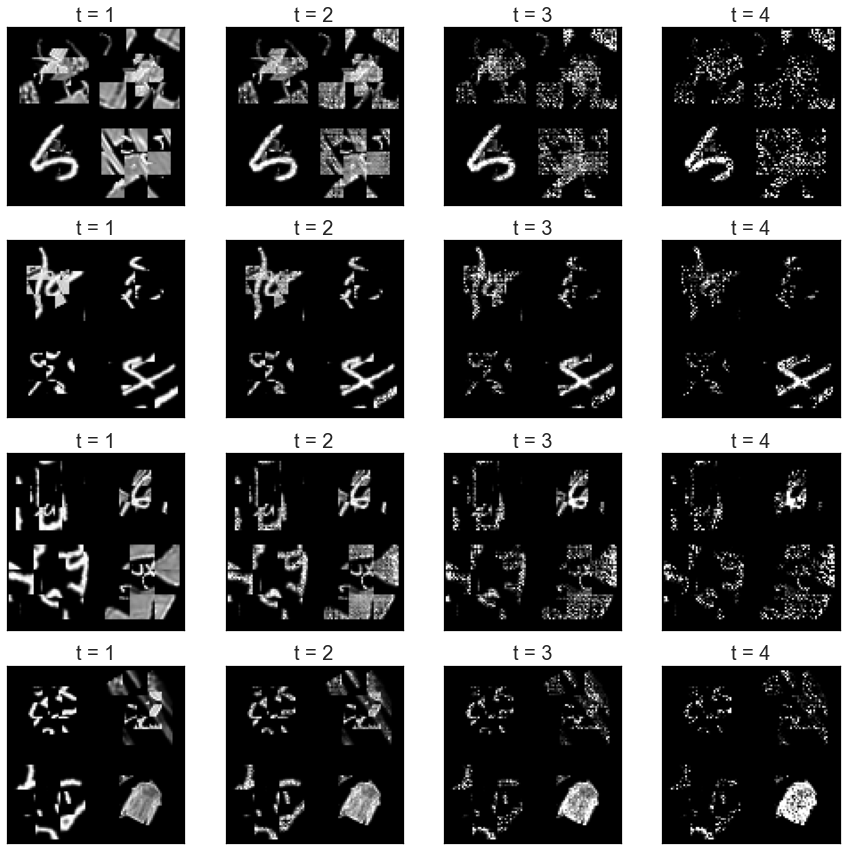

In [18]:
plt.figure(figsize=(15,15))
for i in np.arange(4):
    print('True label:',np.where(labels_v[i,:])[0][0],'; Predicted label:',np.where(outputs[5][i].detach().numpy()==np.max(outputs[5][i].detach().numpy()))[0][0])
    for j in np.arange(t_steps):
        plt.subplot(4,t_steps,(i)*t_steps+j+1)
        plt.imshow(outputs[0][j][i,0,:,:].detach().numpy(),cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title('t = '+str(j+1),fontsize=20)

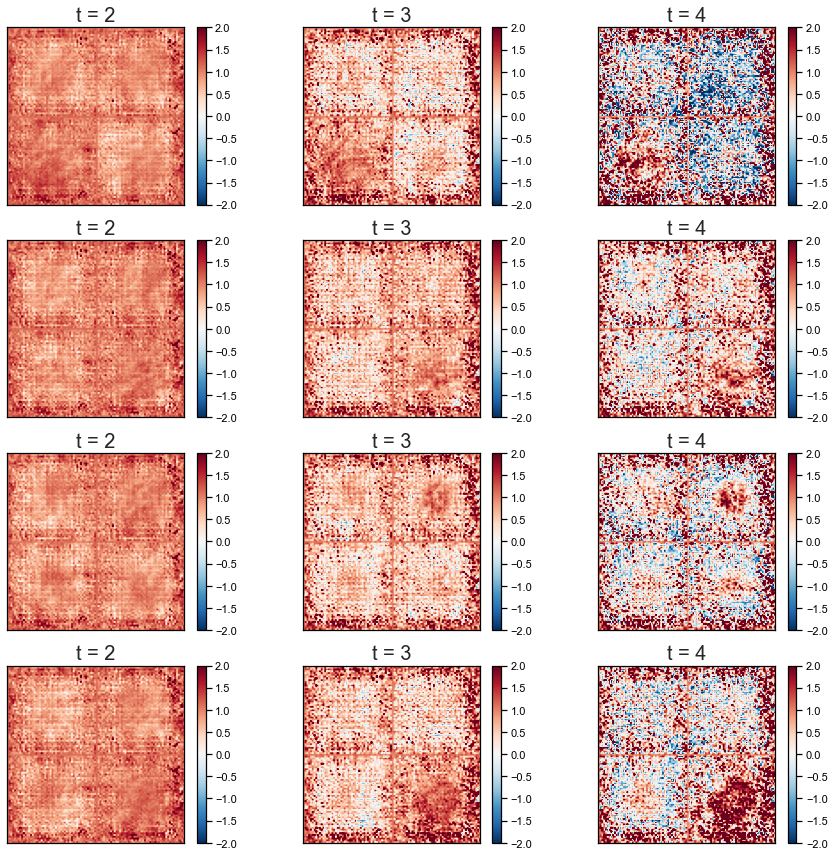

In [19]:
plt.figure(figsize=(15,15))
for i in np.arange(4):
    for j in np.arange(t_steps-1):
        plt.subplot(4,t_steps-1,(i)*(t_steps-1)+j+1)
        if g_h == 1:
            plt.imshow(out_fbr_comb[0][1][j][i,0,:,:].detach().numpy()+1,cmap='RdBu_r')
        else:
            plt.imshow(out_fbr_comb[0][0][j][i,0,:,:].detach().numpy()+1,cmap='RdBu_r')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        plt.clim([-2,2])
        plt.title('t = '+str(j+2),fontsize=20)

## Decoding auxiliary variables and category from layer activations: Results

Output category accuracies:  0.81226
Auxiliary variable avg. decoding through time:  [0.65223333 0.730225   0.82524583 0.84927083]
Auxiliary variable avg. decoding through layer depth:  [0.70119167 0.7465125  0.81060833 0.7986625 ]


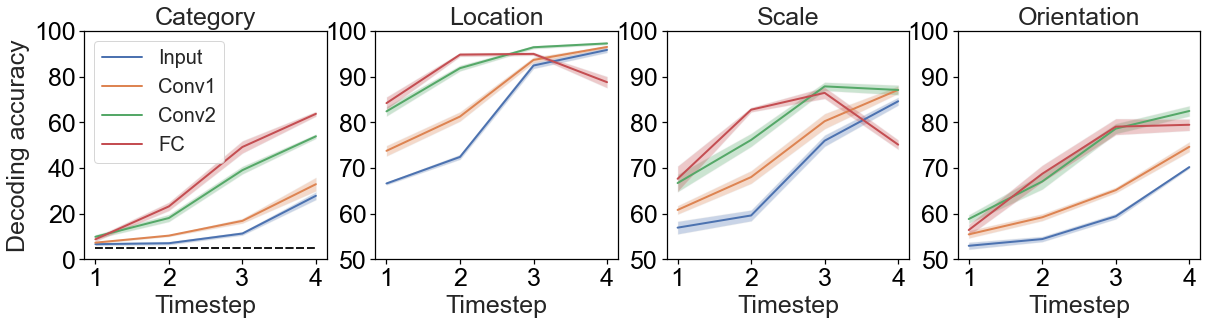

In [20]:
dec_acc1 = np.zeros([4,t_steps,5,2,5])
out_acc1 = np.zeros([5,2])
fbr_accs_all_comb1 = np.zeros([4,t_steps-1,2,5,5])
for net_num1 in np.arange(5):
    dec_accs_str = 'analyses/'+'dec_acc'+'rnn_bglt_'+str(b_h)+str(g_h)+str(l_h)+str(t_h)+'_t_'+str(t_steps)+'_num_'+str(net_num1+1)+'.npy'
    with open(dec_accs_str, 'rb') as f:
        dec_acc = np.load(f)
        out_acc = np.load(f)
        fbr_accs_all_comb = np.load(f)
    dec_acc1[:,:,0,:,net_num1] = np.mean(dec_acc[:,:,0,:,:],3)
    dec_acc1[:,:,1,:,net_num1] = np.mean(np.mean(dec_acc[:,:,1:3,:,:],4),2)
    dec_acc1[:,:,2:,:,net_num1] = np.mean(dec_acc[:,:,3:,:,:],4)
    out_acc1[net_num1,:] = np.mean(out_acc,1)
    fbr_accs_all_comb1[:,:,:,0,net_num1] = np.mean(fbr_accs_all_comb[:,:,:,0,:],3)
    fbr_accs_all_comb1[:,:,:,1,net_num1] = np.mean(np.mean(fbr_accs_all_comb[:,:,:,1:3,:],4),3)
    fbr_accs_all_comb1[:,:,:,2:,net_num1] = np.mean(fbr_accs_all_comb[:,:,:,3:,:],4)

var_names = ['Category','Location','Scale','Orientation']
plt.figure(figsize=(20,4.2))
legend_labels = ['Input','Conv1','Conv2','FC']
for i in np.arange(4):
    plt.subplot(1,4,i+1)
    for j in np.arange(4):
        plt.plot(np.arange(t_steps)+1,np.transpose(np.mean(dec_acc1[j,:,i,0,:],1))*100., label=legend_labels[j])
        y = np.transpose(dec_acc1[j,:,i,0,:])*100.
        ci = 1.96 * np.std(y,0)/np.sqrt(5)
        plt.fill_between(np.arange(t_steps)+1, (np.mean(y,0)-ci), (np.mean(y,0)+ci), alpha=.3, label='_nolegend_')
    if i == 0:
        plt.plot(np.arange(t_steps)+1,0*np.transpose(np.mean(dec_acc1[0:4,:,i,0,:],2))+5,'k--', label='_nolegend_')
    plt.xticks(np.arange(t_steps)+1,fontsize=25)
    plt.yticks(fontsize=25)
    if i == 0:
        plt.legend(fontsize=20)
        plt.ylim([0,100])
        plt.ylabel('Decoding accuracy',fontsize=25)
    else:
        plt.ylim([50,100])
    plt.tick_params(axis=u'both', which=u'both',length=5,color='black',top=False, bottom=True, left=True, right=False)
    plt.title(var_names[i],fontsize=25)
    plt.xlabel('Timestep',fontsize=25)
    
print('Output category accuracies: ',np.mean(out_acc1,0)[0])
print('Auxiliary variable avg. decoding through time: ',np.mean(np.mean(np.mean(dec_acc1[:,:,1:4,0,:],3),2),0))
print('Auxiliary variable avg. decoding through layer depth: ',np.mean(np.mean(np.mean(dec_acc1[:,:,1:4,0,:],3),2),1))

## Decoding auxiliary variables and category from the recurrent flows: Results

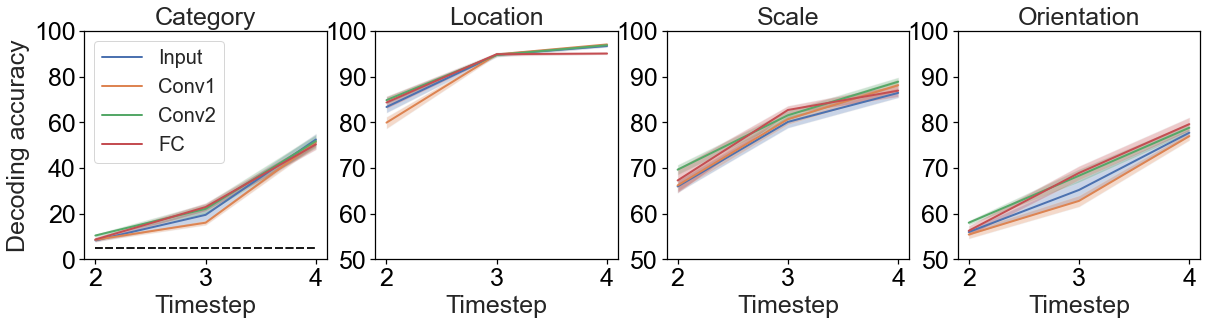

In [21]:
plt.figure(figsize=(20,4.2))
legend_labels = ['Input','Conv1','Conv2','FC']
for i in np.arange(4):
    plt.subplot(1,4,i+1)
    for j in np.arange(4):
        plt.plot(np.arange(t_steps-1)+2,np.transpose(np.mean(fbr_accs_all_comb1[j,:,1,i,:],1))*100., label=legend_labels[j])
        y = np.transpose(fbr_accs_all_comb1[j,:,1,i,:])*100.
        ci = 1.96 * np.std(y,0)/np.sqrt(5)
        plt.fill_between(np.arange(t_steps-1)+2, (np.mean(y,0)-ci), (np.mean(y,0)+ci), alpha=.3, label='_nolegend_')
    if i == 0:
        plt.plot(np.arange(t_steps-1)+2,0*np.transpose(np.mean(fbr_accs_all_comb1[0:4,:,1,i,:],2))+5,'k--', label='_nolegend_')
    plt.xticks(np.arange(t_steps-1)+2,fontsize=25)
    plt.yticks(fontsize=25)
    if i == 0:
        plt.legend(fontsize=20)
        plt.ylim([0,100])
        plt.ylabel('Decoding accuracy',fontsize=25)
    else:
        plt.ylim([50,100])
    plt.tick_params(axis=u'both', which=u'both',length=5,color='black',top=False, bottom=True, left=True, right=False)
    plt.title(var_names[i],fontsize=25)
    plt.xlabel('Timestep',fontsize=25)

## Perturbation analysis: Results

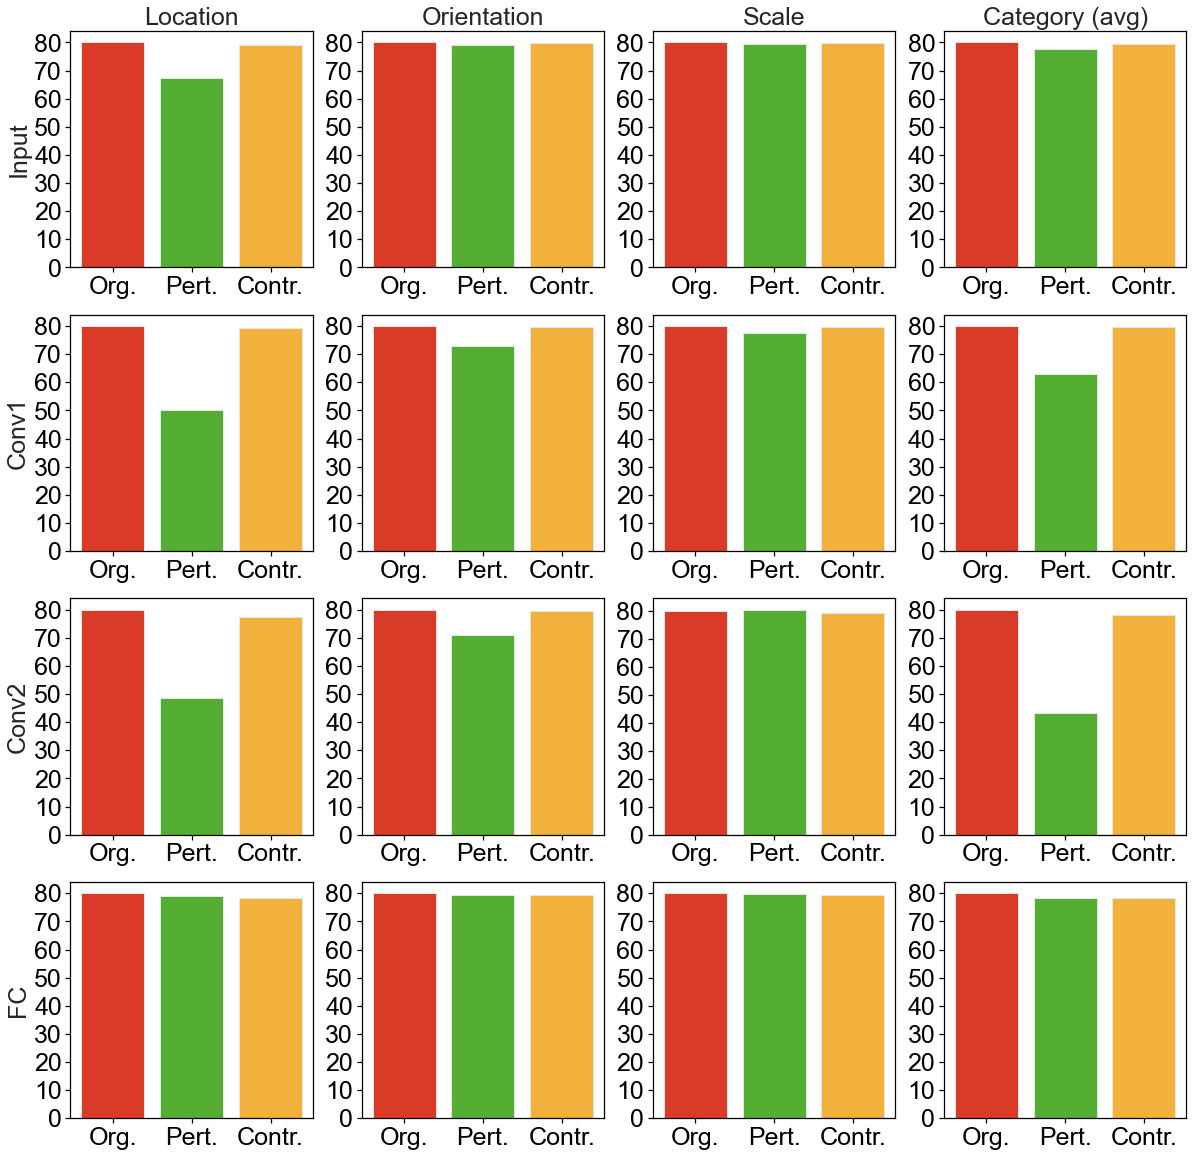

In [22]:
org_accs_h = np.zeros([5,1])
pert_accs_h = np.zeros([5,4,2,4,3])
pert_accs_cat_sep = np.zeros([5,2,2,4,3])
for net_num1 in np.arange(5):
    out_str = 'analyses/'+'fb_perturb-'+'rnn_bglt_'+str(b_h)+str(g_h)+str(l_h)+str(t_h)+'_t_'+str(t_steps)+'_num_'+str(net_num1+1)+'.npy'
    with open(out_str, 'rb') as f:
        original_accuracy = np.load(f)
        perturbed_accuracies = np.load(f)
    org_accs_h[net_num1] = np.mean(original_accuracy)*100
    pert_accs_h[net_num1,0,:,:,:] = np.mean(np.mean(perturbed_accuracies[0:2,:,:,:,:],4),0)*100
    pert_accs_h[net_num1,1:3,:,:,:] = np.mean(perturbed_accuracies[2:4,:,:,:,:],4)*100
    pert_accs_h[net_num1,3,:,:,:] = np.mean(np.mean(perturbed_accuracies[4:6,:,:,:,:],4),0)*100
    pert_accs_cat_sep[net_num1,0,:,:,:] = np.mean(np.mean(perturbed_accuracies[4:5,:,:,:,:],4),0)*100
    pert_accs_cat_sep[net_num1,1,:,:,:] = np.mean(np.mean(perturbed_accuracies[5:6,:,:,:,:],4),0)*100

pert_names = ['Location','Orientation','Scale','Category (avg)']
lay_names = ['Input','Conv1','Conv2','FC']
plt.figure(figsize=(20,20))
for lay in np.arange(4):
    for pert in np.arange(4):
        plt.subplot(4,4,lay*4+pert+1)
        plt.bar(1,np.mean(org_accs_h),color='#DA3B26')
        plt.bar(2,np.mean(pert_accs_h[:,pert,0,lay,2]),color='#54AE32')
        plt.bar(3,np.mean(pert_accs_h[:,pert,1,lay,2]),color='#F2B13D')
        plt.xticks(np.arange(3)+1,['Org.','Pert.','Contr.'],fontsize=25)
        plt.yticks(fontsize=25)
        if lay == 0:
            plt.title(pert_names[pert],fontsize=25)
        if pert == 0:
            plt.ylabel(lay_names[lay],fontsize=25)
        plt.tick_params(axis=u'both', which=u'both',length=5,color='black',top=False, bottom=True, left=True, right=False)

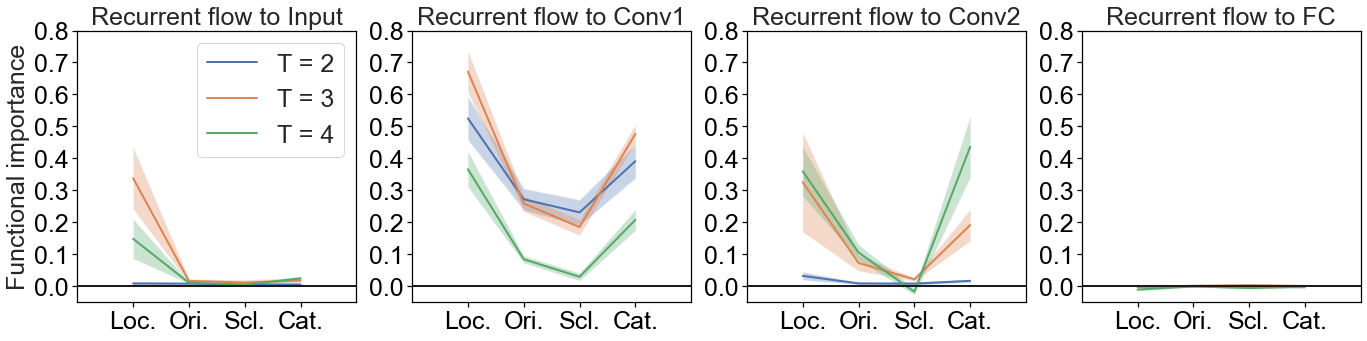

In [23]:
perturbed_relative = np.zeros([4,4,3])
pert_rel_se = np.zeros([4,4,3])
for lay in np.arange(4):
    for pert in np.arange(4):
        for th in np.arange(3):
            perturbed_relative[pert,lay,th] = np.mean((pert_accs_h[:,pert,1,lay,th] - pert_accs_h[:,pert,0,lay,th])/org_accs_h)
            pert_rel_se[pert,lay,th] = 1.96*np.std((pert_accs_h[:,pert,1,lay,th] - pert_accs_h[:,pert,0,lay,th])/org_accs_h)/np.sqrt(5)
plt.figure(figsize=(23,5))
pert_names = ['Loc.','Ori.','Scl.','Cat.']
legend_labels = ['T = 2','T = 3','T = 4']
for lay in np.arange(4):
    plt.subplot(1,4,lay+1)
    for th in np.arange(3):
        plt.plot(np.arange(4)+1,perturbed_relative[:,lay,th],label=legend_labels[th])
        plt.fill_between(np.arange(4)+1, (perturbed_relative[:,lay,th]-pert_rel_se[:,lay,th]), (perturbed_relative[:,lay,th]+pert_rel_se[:,lay,th]), alpha=.3,label='_nolegend_')
    plt.plot(np.arange(6),0*np.arange(6),'k-',label='_nolegend_')
    plt.xticks(np.arange(4)+1,pert_names,fontsize=25)
    plt.yticks(fontsize=25)
    plt.ylim([-.05,0.8])
    plt.xlim([0,5])
    plt.title('Recurrent flow to '+lay_names[lay],fontsize=25)
    if lay == 0:
        plt.legend(['T = 2','T = 3','T = 4'],fontsize=25)
        plt.ylabel('Functional importance',fontsize=25)
    plt.tick_params(axis=u'both', which=u'both',length=5,color='black',top=False, bottom=True, left=True, right=False)
# plt.savefig('fig5.png', dpi=500)

### Functional importance as a function of perturbation within category domain or across domain

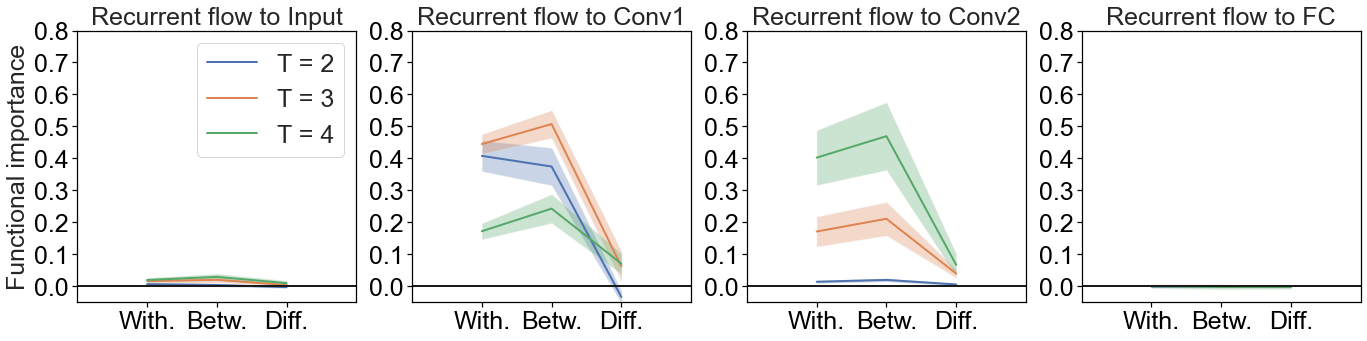

In [24]:
perturbed_relative = np.zeros([3,4,3])
pert_rel_se = np.zeros([3,4,3])
for lay in np.arange(4):
    for th in np.arange(3):
        for pert in np.arange(2):
            perturbed_relative[pert,lay,th] = np.mean((pert_accs_cat_sep[:,pert,1,lay,th] - pert_accs_cat_sep[:,pert,0,lay,th])/org_accs_h)
            pert_rel_se[pert,lay,th] = 1.96*np.std((pert_accs_cat_sep[:,pert,1,lay,th] - pert_accs_cat_sep[:,pert,0,lay,th])/org_accs_h)/np.sqrt(5)
        perturbed_relative[2,lay,th] = perturbed_relative[1,lay,th] - perturbed_relative[0,lay,th]
        pert_rel_se[2,lay,th] = 1.96*np.std((pert_accs_cat_sep[:,1,1,lay,th] - pert_accs_cat_sep[:,1,0,lay,th])/org_accs_h-(pert_accs_cat_sep[:,0,1,lay,th] - pert_accs_cat_sep[:,0,0,lay,th])/org_accs_h)/np.sqrt(5)
plt.figure(figsize=(23,5))
legend_labels = ['T = 2','T = 3','T = 4']
for lay in np.arange(4):
    plt.subplot(1,4,lay+1)
    for th in np.arange(3):
        plt.plot(np.arange(3)+1,perturbed_relative[:,lay,th],label=legend_labels[th])
        plt.fill_between(np.arange(3)+1, (perturbed_relative[:,lay,th]-pert_rel_se[:,lay,th]), (perturbed_relative[:,lay,th]+pert_rel_se[:,lay,th]), alpha=.3,label='_nolegend_')
    plt.plot(np.arange(5),0*np.arange(5),'k-',label='_nolegend_')
    plt.xticks(np.arange(3)+1,['With.','Betw.','Diff.'],fontsize=25)
    plt.yticks(fontsize=25)
    plt.ylim([-.05,0.8])
    plt.xlim([0,4])
    plt.title('Recurrent flow to '+lay_names[lay],fontsize=25)
    if lay == 0:
        plt.legend(['T = 2','T = 3','T = 4'],fontsize=25)
        plt.ylabel('Functional importance',fontsize=25)
    plt.tick_params(axis=u'both', which=u'both',length=5,color='black',top=False, bottom=True, left=True, right=False)
# plt.savefig('fig5.png', dpi=500)